# Residual Learning
> Understanding the role of residuals in model training.

- toc: true 
- badges: true
- comments: true
- sticky_rank: 1
- author: Abhishek Sharma
- image: images/res_learning.png
- categories: [deeplearning, math]

## What is a residual?

Residual is the difference between actual and estimated value.

## What is residual learning?

In the context of ensemble learning, a base model is used to fit the residuals to make the ensemble model more accurate. In deep learning, various architectures use a block/layer to fit the residual to improve the performance of the DNN.

## How does Gradient Boosting Machines use residuals?

We will try to deconstruct how GBM works using DecisionTrees on a regression task.

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [3]:
X, y = datasets.make_regression(n_samples=1000, random_state=41)
Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.2, random_state=41)

In [4]:
from sklearn.tree import DecisionTreeRegressor

In [5]:
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=41)
tree_reg1.fit(Xtr, ytr)

y2 = ytr - tree_reg1.predict(Xtr)

tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=41)
tree_reg2.fit(Xtr, y2)

y3 = y2 - tree_reg2.predict(Xtr)

tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=41)
tree_reg3.fit(Xtr, y3)

y_pred = sum(tree.predict(Xva) for tree in (tree_reg1, tree_reg2, tree_reg3))

### Gradient Boosting

**How does residuals play a part in Gradient Boosting Learning?**

- Train a base learner `tree_reg1` to fit data (`X`) and labels (`y`)
- Train a base learner `tree_reg2` that fits on data (`X`) and **residuals** between the `label` and predicted value of base learner `tree_reg1`. Essentially, we are using a base learner to learn the **residuals**.
- Finally the result of all the base learners are added to make the final prediction.

The above code is equivalent to calling the GradientBoostingRegressor with `3` base learners.

In [6]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=41)
gbrt.fit(Xtr, ytr)

gb_preds = gbrt.predict(Xva)

In [7]:
sum(y_pred - gb_preds)

-4.554578936222242e-12

## Role of residual learning in training deep networks?

### Why do we need ResNets?

Research to develop better architectures which perform better has led researchers to go deeper with a notion that to a certain extent going deeper would yield better performance.

But we realized that going deeper brings problems of its own, model become difficult to train. In 2014, VGG had only 19 layers while in 2015 ResNet had 152 layers and a far better performance, one can say at an initial glance that ResNet wins because it has more number of layers. Ofcourse that is the case but it also introduces a trick called "residual learning" that helps achieve this performance.

CNN models have evolved over time from LeNet-5 ( 5 layers ) and AlexNet ( 8 layers ) to VGGNet (16-19) and later GoogleNet ( 22 layers ). According to experimental results of VGGNet, depth of the network plays a crucial role in model's performance.

Please find below tables extracted from [VGG paper](https://arxiv.org/pdf/1409.1556.pdf) that showcases that deeper we go better the effect.

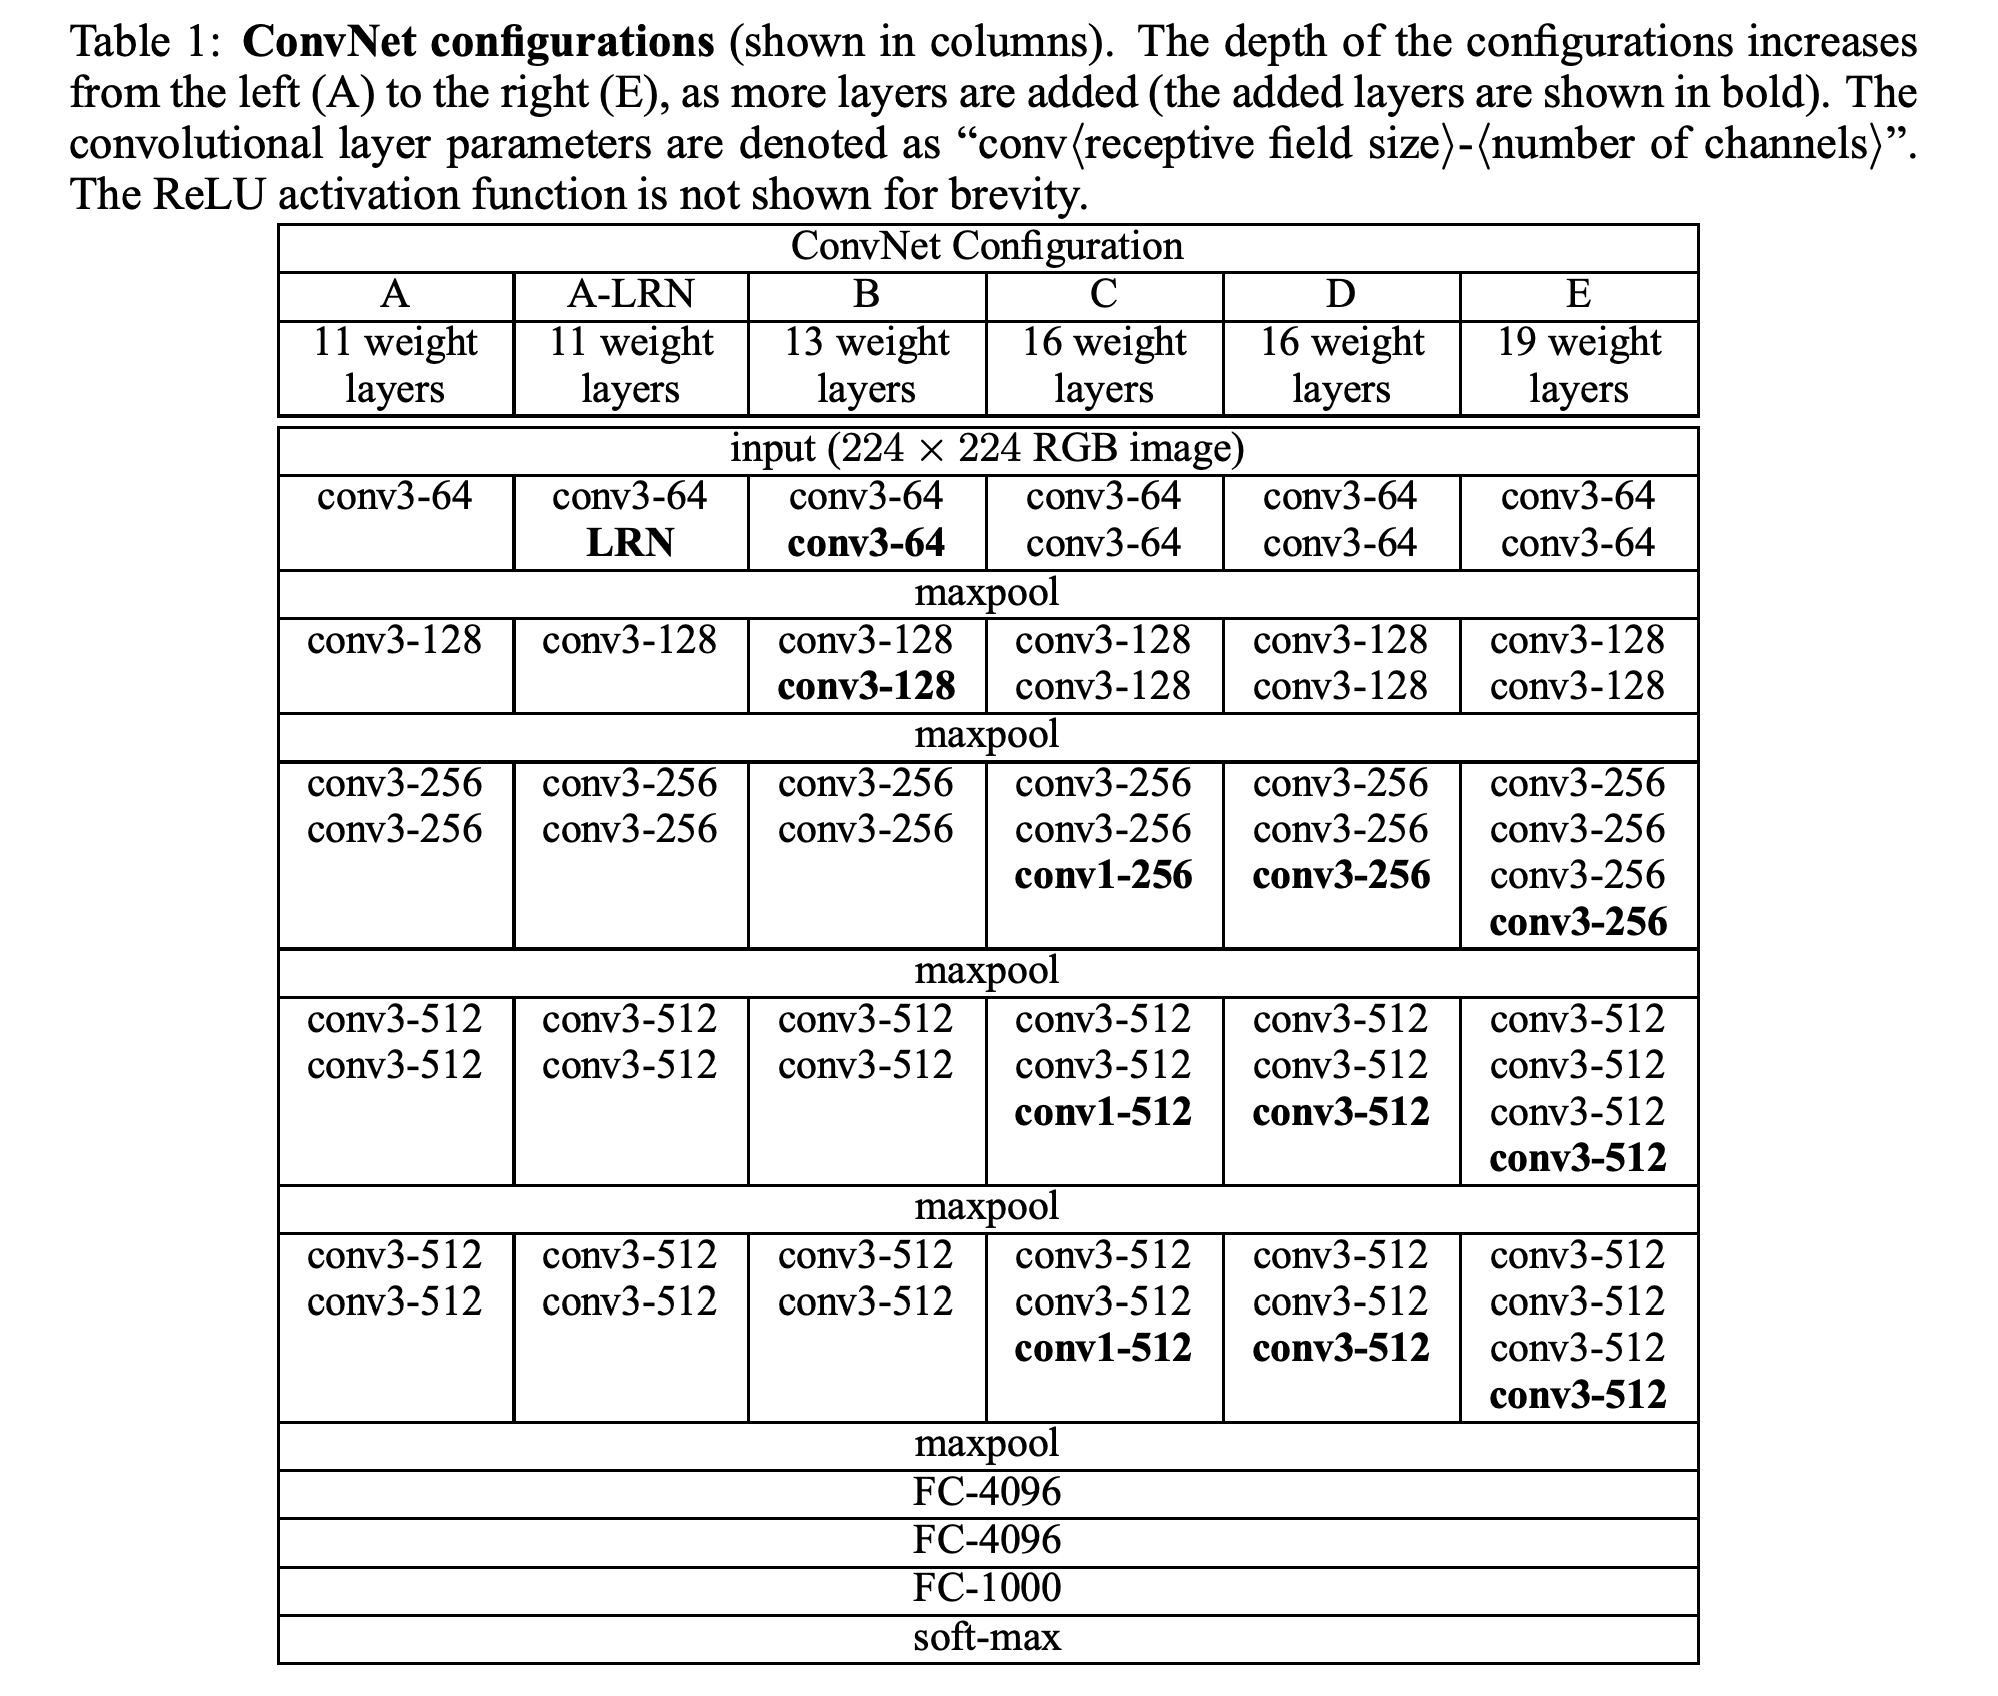

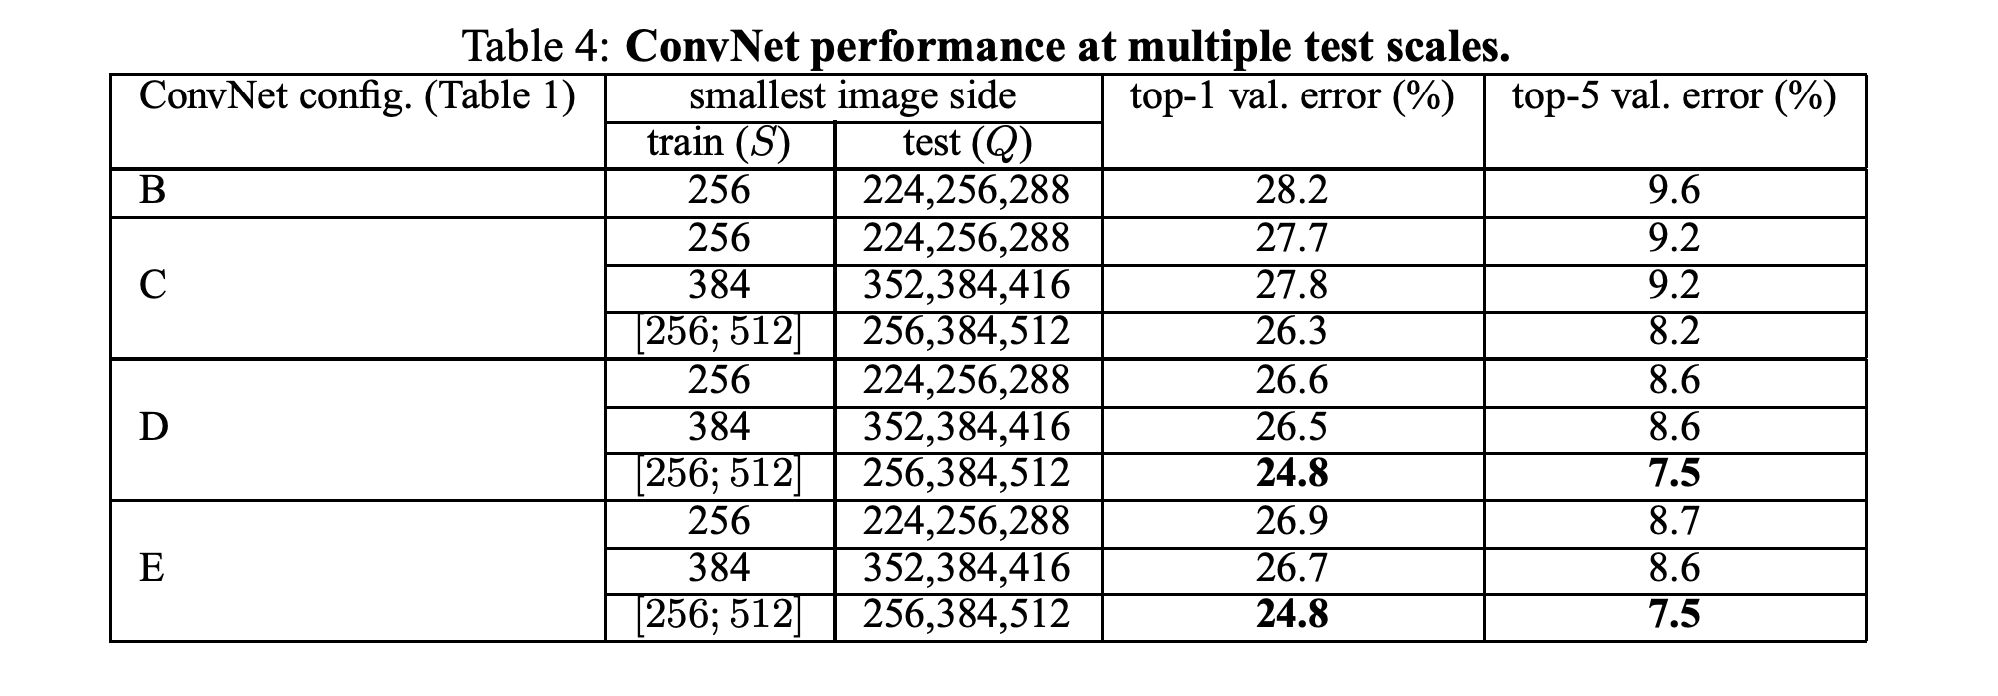

### Are deeper networks really better?

Later in various experiments it was found out that model performance increases with depth upto a certain extent further which it often decreases. What could be the reasons for that could it be following

- Overfitting.
- Vanishing/Exploding Gradients.

#### Overfitting

In the [Resnet](https://arxiv.org/pdf/1512.03385.pdf) paper the authors tried this following experiment

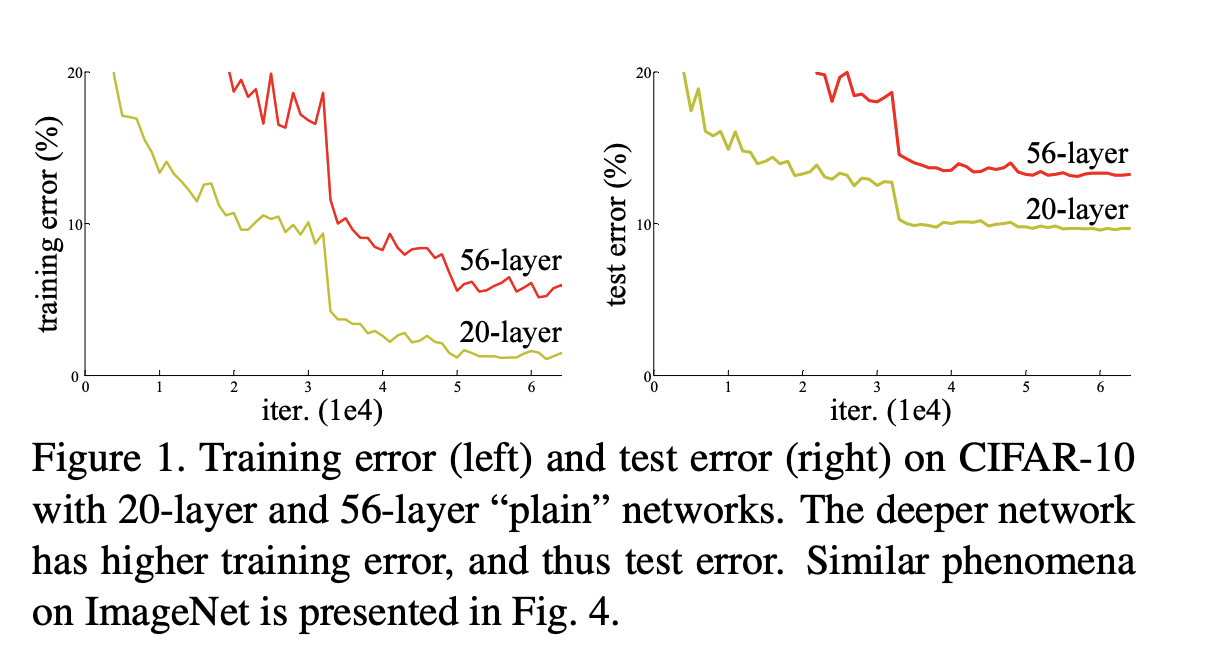

The y-axis on the left figure represents **training error** and the y-axis on the right figure represents **test error** and x-axes on the both the figures represent the number of iterations.

We can see that the 20-layer network trained for a large number of iterations yields in low training error but corresponding test error is relatively large. This is a case of **over-fitting** ( we are performing better on training compared to test dataset ).

In addition to this the authors also trained a network with 56-layers and found out that error of this network in both training and testing is large compared to the 20-layer network. Thus performance degradation has nothing to do with `overfitting`.

#### Vanishing/Exploding Gradients

Vanishing/Exploding gradients make the model difficult to train but there are already some techniques like Batch Normalization to alleviate this problem.

Let's try to understand the example presented by author in the paper

Suppose we have a following network which can perform good on training and test datasets.

![](images/plain_network.drawio.png)

Then we augment the architecture in the following way to add more layers. The parameters of the first 4 layers are copied from the above network and these parameters remain unchanged during training.

![](images/plain_network_more_layers.drawio.png)

In theory the performance of the second network should be better than first network since we have more layers which could extract useful features and suppose we find out that the second network performs worse, then one explanation provided by the authors is that since we have copied the parameters of first 4 layers in the second network and if they are enough to meet the performance requirements then the newly added layers are a bit redundant. To maintain the level of performance, the newly added functions has to serve as an **identity mapping** that is the net effect of the purple layers should be `f(x) = x`, in this way we would not experience model degradation.

This is what the authors observed that the non-linear expression of the traditional multi-layer network structure has difficulty expressing the identity mapping which leads to model degradation.

### How do we tackle model degradation then?

Assuming that a relatively shallow network can already achieve good results, then even if the network is piled up with more layers the effect of the model should not deteriorate.

In reality, however this is the problem, `doing nothing` happens to be a very challenging task.

Presence of non-linear activation functions makes the input-to-output process almost irreversible. Non-linearity gives the model endless possibilities but it also makes the network forget the original intention.

The quality of `not forgetting the original intention/doing nothing` is managed by identity mapping.

### Residual Block

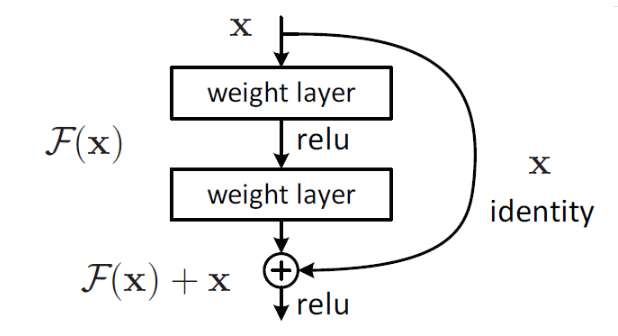

In fact, it is difficult for existing neural networks to fit the underlying identity mapping function H(x) = x.But if the network is designed such that H(x) = F(x) + x, then the identity map could be used as part of the network.

The problem can be transformed into learning a residual function F(x) = H(x) - x. As long as F(x)=0, an identity map H(x) = x is formed. The loop in the figure is called a shortcut connection. By jumping before the activation function, the output of the previous layer or layers is added to the output calculated by this layer, and the result of summation is input to the next activation function as the output of this layer.

The idea of the skip connection is to expressed the output as a linear superposition of a nonlinear transformation of the input and the input. There is no new formula, no new theory, but a new expression.

#### Why is residual learning relatively easier?

Intuitively, residual learning requires less learning, because residuals are generally relatively small and the learning difficulty is less. However, we can analyze this problem from a mathematical point of view. First, the residual unit can be expressed as:

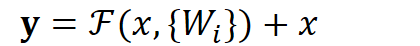

$F(x, \{W_i\})$ is the goal of our learning, that is, the residual of the output and input i.e. $y-x$. If we further expand

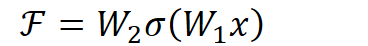

$\sigma$ refers to Relu, while $W_1$, $W_2$ refer to two layers of weights. When $F(x,\{W_i\})$ learns to have a `0` value then $y = x$, this is what we call identity mapping. 

Why can't we have $y=f(x,\{W_i\})$ instead and no skip connections?

- Because $f(x,\{W_i\})$ has a ReLU activation function in the middle so if `x <= 0` then `y = 0` which would violate the identity mapping principle.

### Experiments

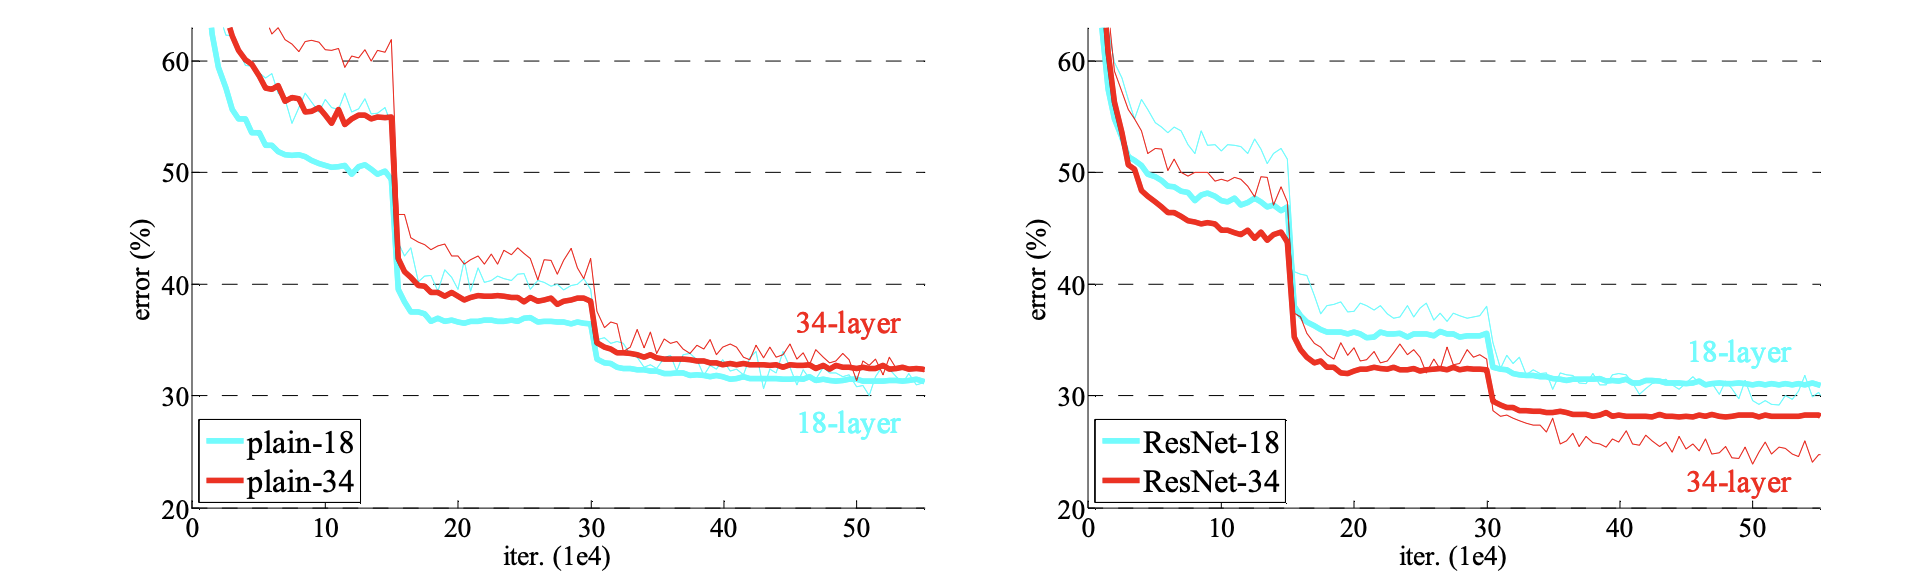

Taken directly from Resnet paper

>Training on ImageNet. Thin curves denote training error, and bold curves denote validation error of the center crops. Left: plain networks of 18 and 34 layers. Right: ResNets of 18 and 34 layers. In this plot, the residual networks have no extra parameter compared to their plain counterparts.

### Summary

- Shortcut connections/residual connections/skip connections/skip connections, etc. are all one thing, there is no new theory, just a new expression.
- Problem of model degradation when deepening the network could be somewhat alleviated using residual learning.

### References

- [Resnet paper](https://arxiv.org/pdf/1512.03385.pdf)
- [VGG](https://arxiv.org/pdf/1409.1556.pdf)